In [1]:
# Import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, \
recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [6]:
df=pd.read_csv('data/Sports_ref_2016.csv').drop('Unnamed: 0',axis=1)

In [38]:
df.drop(['home_win'],axis=1,inplace=True)

In [24]:
df2=pd.read_csv('data/Season_2016_fav_win.csv')

In [39]:
df3=pd.concat([df,df2],axis=1)

In [41]:
df3.home_win.value_counts(normalize=True)

1    0.530066
0    0.469934
Name: home_win, dtype: float64

In [54]:
df3=df3.drop(['H_win_probability_subtracted','A_win_probability_subtracted','A_Opp_win_probability_subtracted',
         'H_Opp_win_probability_subtracted'],axis=1)

In [55]:
X=df3.drop(['home_win','H_Tm','A_Tm','H_name','A_name','fav_win'],axis=1)
y=df3['home_win']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [57]:
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

In [58]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [59]:
def feature_select(X_train,y_train,estimator,min_features,step=1):
    estimator2=estimator()
    selector=RFECV(estimator2,min_features_to_select=min_features,step=step)
    selector.fit(X_train,y_train)
    selector.ranking_
    feature_dict=dict(zip(X_train.columns, selector.ranking_))
    best_pred = [k for (k,v) in feature_dict.items() if v == 1]
    
    
    return best_pred

In [60]:
feats= feature_select(X_train_scaled,y_train,LogisticRegression,min_features=10)

In [61]:
X_train_best_log = X_train_scaled[feats]
X_test_best_log = X_test_scaled[feats]

In [62]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    grid_logreg.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    logreg_params = gs.best_params_
    
    # Use best penalty from best_params
    logreg_penalty = logreg_params['penalty']
    print(f'Penalty: {logreg_penalty}')
    
    # Use best solver from best_params
    logreg_solver = logreg_params['solver']
    print(f'Solver: {logreg_solver}')
    
    # Instantiate & fit LogReg model
    log = LogisticRegression(random_state=42, penalty=logreg_penalty, solver=logreg_solver)
    log.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = log.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(log, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = log.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = log.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
  
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(log, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(log, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(log, X_train, y_train)
    plot_confusion_matrix(log, X_test, y_test)

Penalty: l1
Solver: saga
Mean Cross-Val Score: 0.5793391539966881
Train Mean Accuracy: 0.5853926414058209
Test Mean Accuracy: 0.5584843492586491
Recall Score: 0.6676829268292683
Precision Score: 0.5793650793650794
F1 Score: 0.6203966005665723


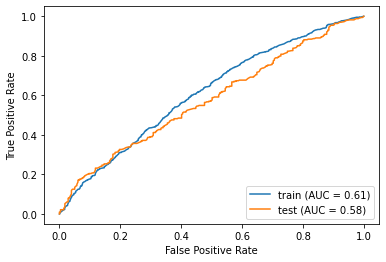

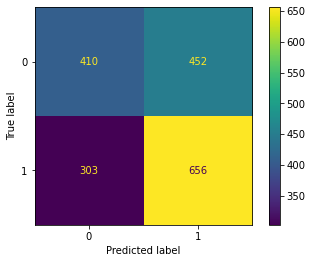

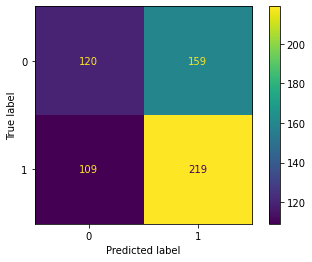

In [63]:
logreg(X_train_best_log,X_test_best_log,y_train,y_test)

In [64]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [65]:
feature_importance=pd.DataFrame(dtree.feature_importances_)
feature_importance=feature_importance.T

In [71]:
X_train.columns

Index(['H_BA_against', 'H_OBP_against', 'H_SLG_against', 'H_OPS_against',
       'H_BAbip_against', 'H_HR%_against', 'H_p_SO%', 'H_p_BB%', 'H_p_EV',
       'H_p_HardH%',
       ...
       'A_Opp_fly_balls', 'A_Opp_line_drives', 'A_Opp_unknown_bat_type',
       'A_Opp_game_score', 'A_Opp_inherited_runners', 'A_Opp_inherited_score',
       'A_Opp_win_probability_by_pitcher', 'A_Opp_base_out_runs_saved',
       'A_median_odds', 'home_fav'],
      dtype='object', length=240)

In [73]:
feature_importance.columns=X_train.columns

In [76]:
#feature_importance.to_csv('feature_importance2.csv')

In [81]:
zero_importance=['H_OBP_against','H_OPS_against','H_BAbip_against','H_HR%_against','H_p_HardH%','H_p_GB/FB',
                 'H_p_RE24','H_DefEff','H_Ch','H_E','H_DP','H_Rdrs/yr','H_SO%','A_BAbip_against',
                'A_p_RE24','A_RA/G','A_DefEff','A_DP','A_Fld%','A_Rtot/yr','A_Rgood','A_rOBA','A_ISO','A_HR%',
                'A_SO%','A_LD%','A_GB%','A_FB%','A_GB/FB','A_Pull%','H_runs','H_hits','H_earned_runs',
                 'H_bases_on_balls','H_strikeouts','H_batting_average','H_win_probability_added',
                 'H_strikes_by_contact','H_strikes_swinging','H_strikes_looking','H_grounded_balls','H_line_drives',
                'H_base_out_runs_saved','H_Opp_runs','H_Opp_earned_runs','H_Opp_on_base_percentage',
                 'H_Opp_average_leverage_index','H_Opp_assists','H_Opp_HR','H_Opp_strikes_by_contact',
                 'H_Opp_line_drives','H_Opp_unknown_bat_type','A_at_bats','A_rbi','A_earned_runs','A_bases_on_balls',
                 'A_strikeouts','A_plate_appearances','A_pitches','A_win_probability_for_offensive_player',
                 'A_average_leverage_index','A_win_probability_added','A_assists','A_line_drives','A_unknown_bat_type',
                 'A_inherited_runners','A_inherited_score','A_Opp_at_bats','A_Opp_rbi','A_Opp_strikeouts',
                 'A_Opp_strikes','A_Opp_average_leverage_index','A_Opp_putouts','A_Opp_HR','A_Opp_unknown_bat_type']
                 

In [82]:
len(zero_importance)

75

In [160]:
X_zero=df3.drop(zero_importance,axis=1)

In [161]:
X_zero

,H_Tm,H_BA_against,H_SLG_against,H_p_SO%,H_p_BB%,H_p_EV,H_p_LD%,H_p_GB%,H_p_FB%,H_p_WPA,...,A_Opp_line_drives,A_Opp_game_score,A_Opp_inherited_runners,A_Opp_inherited_score,A_Opp_win_probability_by_pitcher,A_Opp_base_out_runs_saved,A_median_odds,home_win,home_fav,fav_win
0,PIT,0.267,0.436,19.6,8.5,88.3,25.7,46.3,19.2,-2.8,...,6.827160,51.438272,1.440994,0.515528,-0.040438,-0.433333,-131.0,1,0,0
1,KCR,0.259,0.423,20.8,8.4,89.4,23.2,43.9,24.3,4.8,...,6.907407,52.382716,1.493750,0.318750,0.035586,0.180864,-123.0,1,0,0
2,TBR,0.255,0.416,22.3,8.1,89.7,23.7,41.2,25.4,-4.0,...,6.240741,50.950617,1.543210,0.493827,0.008802,-0.098765,-141.0,0,0,1
3,OAK,0.263,0.422,19.3,7.6,89.3,25.7,46.2,19.7,-6.3,...,7.006173,51.216049,1.367089,0.360759,0.009222,0.217284,-102.0,0,0,1
4,ARI,0.275,0.454,20.5,9.4,89.6,28.0,45.7,18.6,-11.8,...,7.308642,47.030864,1.559006,0.552795,-0.033364,-0.499383,111.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2423,SFG,0.243,0.392,21.6,7.3,88.8,25.6,44.7,20.5,9.3,...,6.462963,50.617284,1.465409,0.496855,-0.009241,-0.120370,-148.0,1,0,0
2424,WSN,0.234,0.376,24.5,7.8,88.3,26.5,43.1,20.5,9.7,...,7.124224,50.204969,1.685897,0.474359,0.009037,0.202484,-103.0,1,1,1
2425,ARI,0.275,0.454,20.5,9.4,89.6,28.0,45.7,18.6,-11.8,...,6.771605,54.586420,1.341935,0.367742,0.052636,0.115432,139.0,1,1,1
2426,SEA,0.253,0.425,21.4,7.5,89.0,25.7,43.3,22.0,2.9,...,7.037037,52.487654,1.253165,0.443038,0.035278,0.387037,115.0,0,1,0


In [162]:
X=X_zero.drop(['home_win','H_Tm','A_Tm','H_name','A_name','fav_win'],axis=1)
y=X_zero['home_win']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [164]:
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

Penalty: l1
Solver: liblinear
Mean Cross-Val Score: 0.5464037332530484
Train Mean Accuracy: 0.5974739154310819
Test Mean Accuracy: 0.5255354200988468
Recall Score: 0.6189024390243902
Precision Score: 0.5546448087431693
F1 Score: 0.5850144092219021


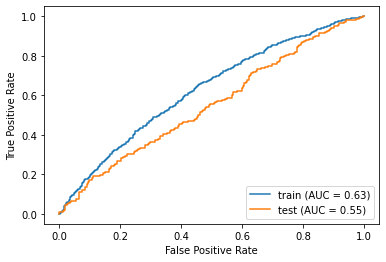

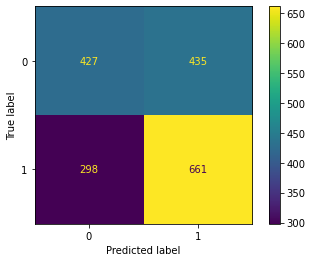

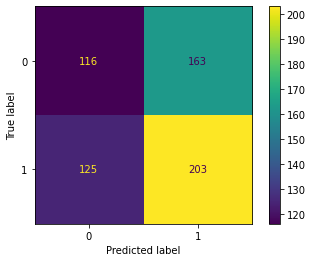

In [165]:
logreg(X_train_scaled,X_test_scaled,y_train,y_test)

In [166]:
X_zero2=X_zero.drop('Unnamed: 0',axis=1)

In [167]:
X=X_zero2.drop(['home_win','H_Tm','A_Tm','H_name','A_name','fav_win'],axis=1)
y=X_zero['home_win']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [169]:
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

Penalty: l2
Solver: newton-cg
Mean Cross-Val Score: 0.544204425711275
Train Mean Accuracy: 0.5941790225151016
Test Mean Accuracy: 0.5387149917627677
Recall Score: 0.6402439024390244
Precision Score: 0.5645161290322581
F1 Score: 0.6


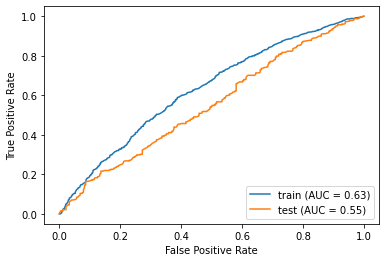

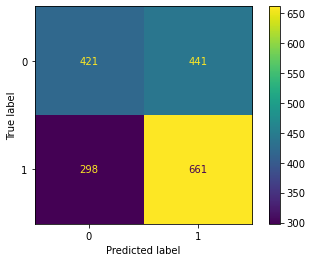

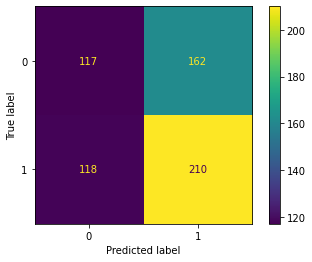

In [170]:
logreg(X_train_scaled,X_test_scaled,y_train,y_test)

In [171]:
top3=['H_p_WPA','H_Opp_strikes_swinging','H_inherited_runners']

In [172]:
X_zero3=X_zero[top3]

In [173]:
X=X_zero3
y=X_zero['home_win']

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [175]:
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

Penalty: l1
Solver: liblinear
Mean Cross-Val Score: 0.5546319433990666
Train Mean Accuracy: 0.556836902800659
Test Mean Accuracy: 0.5799011532125206
Recall Score: 0.725609756097561
Precision Score: 0.5905707196029777
F1 Score: 0.6511627906976745


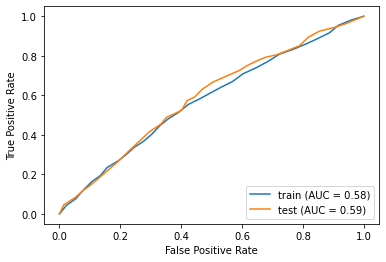

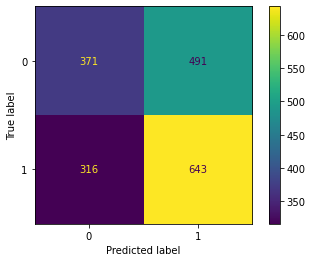

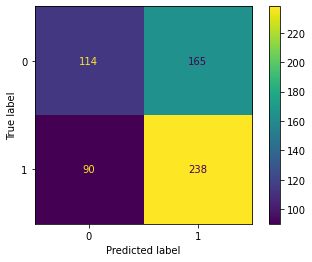

In [176]:
logreg(X_train_scaled,X_test_scaled,y_train,y_test)

In [149]:
over70=['H_p_WPA','H_Opp_strikes_swinging','H_inherited_runners','A_median_odds','A_strikes_by_contact',
     'H_Opp_hits','A_Opp_strikes_swinging']

In [150]:
X_zero4=X_zero[over70]

In [152]:
X=X_zero4
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [153]:
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

Penalty: l1
Solver: liblinear
Mean Cross-Val Score: 0.552983591750715
Train Mean Accuracy: 0.5694673256452498
Test Mean Accuracy: 0.5963756177924218
Recall Score: 0.7530487804878049
Precision Score: 0.6009732360097324
F1 Score: 0.668470906630582


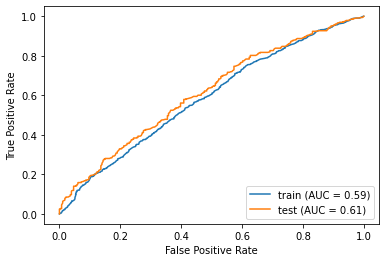

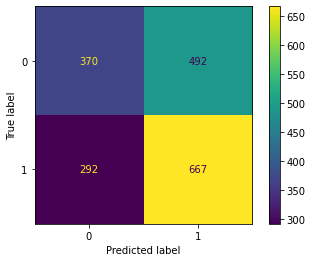

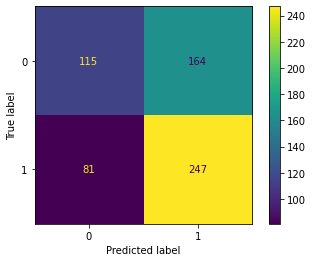

In [154]:
logreg(X_train_scaled,X_test_scaled,y_train,y_test)

In [177]:
over60=['H_p_WPA','H_Opp_strikes_swinging','H_inherited_runners','A_median_odds','A_strikes_by_contact',
     'H_Opp_hits','A_Opp_strikes_swinging','H_Cent%','A_runs','A_p_GB%','H_on_base_plus','A_Opp_line_drives',
       'A_Opp_inherited_runners','H_Opp_strikes_looking']

In [179]:
X_zero5=X_zero[over60]

In [180]:
X=X_zero5
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [181]:
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

Penalty: l2
Solver: newton-cg
Mean Cross-Val Score: 0.5617717898539816
Train Mean Accuracy: 0.5755079626578803
Test Mean Accuracy: 0.5650741350906096
Recall Score: 0.7073170731707317
Precision Score: 0.58
F1 Score: 0.6373626373626374


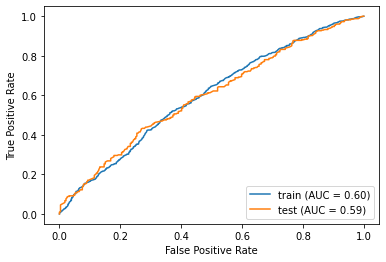

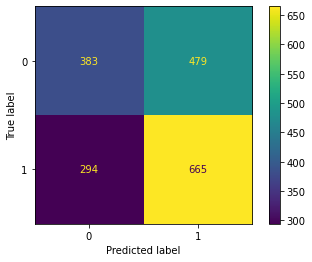

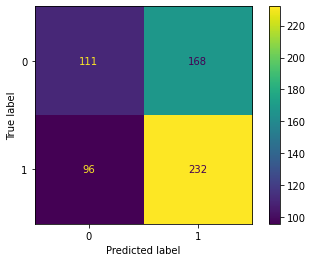

In [182]:
logreg(X_train_scaled,X_test_scaled,y_train,y_test)

In [183]:
over50=['H_p_WPA','H_Opp_strikes_swinging','H_inherited_runners','A_median_odds','A_strikes_by_contact',
     'H_Opp_hits','A_Opp_strikes_swinging','H_Cent%','A_runs','A_p_GB%','H_on_base_plus','A_Opp_line_drives',
       'A_Opp_inherited_runners','H_Opp_strikes_looking','H_Rtot','A_Opp_fly_balls']

In [184]:
X_zero6=X_zero[over50]
X=X_zero6
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

Penalty: l2
Solver: lbfgs
Mean Cross-Val Score: 0.558485623965076
Train Mean Accuracy: 0.5799011532125206
Test Mean Accuracy: 0.5634266886326195
Recall Score: 0.7042682926829268
Precision Score: 0.5789473684210527
F1 Score: 0.6354883081155434


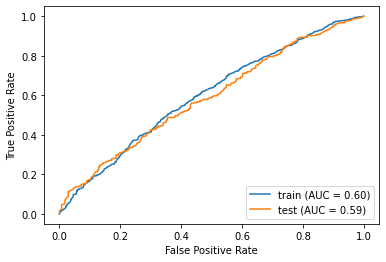

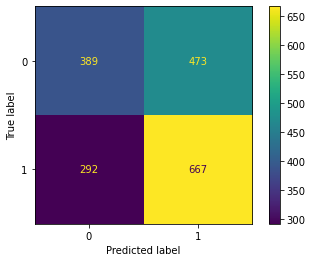

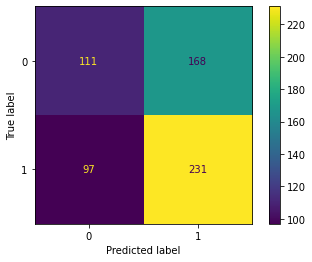

In [185]:
logreg(X_train_scaled,X_test_scaled,y_train,y_test)

In [189]:
over40=['H_p_WPA','H_Opp_strikes_swinging','H_inherited_runners','A_median_odds','A_strikes_by_contact',
     'H_Opp_hits','A_Opp_strikes_swinging','H_Cent%','A_runs','A_p_GB%','H_on_base_plus','A_Opp_line_drives',
       'A_Opp_inherited_runners','H_Opp_strikes_looking','H_Rtot','A_Opp_fly_balls','A_Opp_strikes_by_contact',
       'H_Opp_win_probability_added','H_Rdrs','H_rOBA','A_Opp_base_out_runs_saved','A_Opp_plate_appearances','H_Rbat+',
       'A_WPA','H_Opp_plate_appearances','A_p_LD%','H_HR%']

In [190]:
X_zero7=X_zero[over40]
X=X_zero7
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

Penalty: l2
Solver: newton-cg
Mean Cross-Val Score: 0.56231822971549
Train Mean Accuracy: 0.5853926414058209
Test Mean Accuracy: 0.556836902800659
Recall Score: 0.6585365853658537
Precision Score: 0.579088471849866
F1 Score: 0.616262482168331


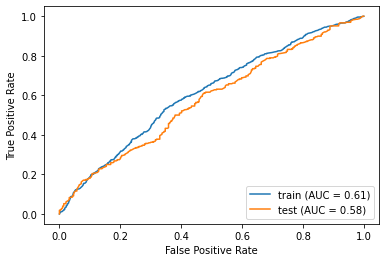

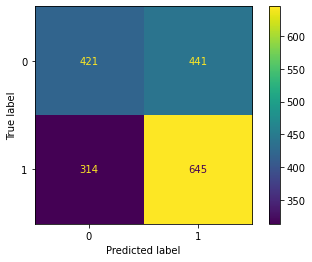

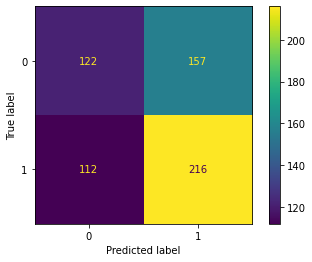

In [191]:
logreg(X_train_scaled,X_test_scaled,y_train,y_test)

In [ ]:
over30=['H_p_WPA','H_Opp_strikes_swinging','H_inherited_runners','A_median_odds','A_strikes_by_contact',
     'H_Opp_hits','A_Opp_strikes_swinging','H_Cent%','A_runs','A_p_GB%','H_on_base_plus','A_Opp_line_drives',
       'A_Opp_inherited_runners','H_Opp_strikes_looking','H_Rtot','A_Opp_fly_balls','A_Opp_strikes_by_contact',
       'H_Opp_win_probability_added','H_Rdrs','H_rOBA','A_Opp_base_out_runs_saved','A_Opp_plate_appearances',
         'H_Rbat+','A_WPA','H_Opp_plate_appearances','A_p_LD%','']